# Stage - 1 : Dataset Augmentation
The New Dataset containing the parent word and its embedding is created. Model used here is a slightly modified skip-gram architecture. Changes Made are Changed the output layer functionality from probabilistic determination to dot product and loss function set to MSE.

In [ ]:
#Stage - 1: Vectorise Vocabulary:

#Generate Embeddings for the words from the dataset

import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, Dot, Flatten, Input
from keras.models import Model
import numpy as np
import pandas as pd
from google.colab import files


file_path = "/content/Augmented_Dataset_v2.xlsx" # Use any word corpus of requirment
data = pd.read_excel(file_path, header=None)

#Tokenise the Dataset
words = [word.lower() for word in data[0].tolist()]
vocab = sorted(set(words))
vocab_size = len(vocab)

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
print(word_to_idx)
print(idx_to_word)

window_size = 3
training_data = []

for i in range(window_size, len(words) - window_size):
    target_word = words[i]
    context_words = [words[j] for j in range(i - window_size, i + window_size + 1) if j != i]
    for context_word in context_words:
        training_data.append((word_to_idx[target_word], word_to_idx[context_word]))
print(training_data)

target_words = np.array([pair[0] for pair in training_data], dtype=np.int32)
context_words = np.array([pair[1] for pair in training_data], dtype=np.int32)

embedding_dim = 20

input_target = Input((1,))
input_context = Input((1,))

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='embedding')

target_embedding = embedding_layer(input_target)
target_embedding = Flatten()(target_embedding)
context_embedding = embedding_layer(input_context)
context_embedding = Flatten()(context_embedding)

dot_product = Dot(axes=1)([target_embedding, context_embedding])

model = Model(inputs=[input_target, input_context], outputs=dot_product)
model.compile(optimizer='adam', loss='mse')


context_words = np.tile(context_words, len(target_words) // len(context_words) + 1)
context_words = context_words[:len(target_words)]

model.fit([target_words, context_words], np.ones_like(target_words), epochs=100, verbose=0)

word_vectors = model.get_layer('embedding').get_weights()[0]

def get_word_vector(word):
    idx = word_to_idx.get(word.lower(), None)
    if idx is None:
        return None
        return None
    else:
        return word_vectors[idx]

output_file_path = 'word_vectors.csv'

with open(output_file_path, 'w') as f:
    f.write('word,vector\n')
    for word in vocab:
        vector = get_word_vector(word)
        if vector is not None:
            vector_str = ','.join(map(str, vector))
            f.write(f'{word.lower()},{vector_str}\n')
        else:
            print(f"Missing vector for word: {word}")

print(f"Word vectors saved to {output_file_path}")

{'about': 0, 'above': 1, 'across': 2, 'adequate': 3, 'advance': 4, 'after': 5, 'against': 6, 'along': 7, 'among': 8, 'ancient': 9, 'angry': 10, 'around': 11, 'artist': 12, 'ask': 13, 'at': 14, 'attach': 15, 'average': 16, 'avoid': 17, 'away': 18, 'baby': 19, 'bad': 20, 'ball': 21, 'bank': 22, 'be': 23, 'beach': 24, 'beautiful': 25, 'become': 26, 'bed': 27, 'before': 28, 'begin': 29, 'behind': 30, 'believe': 31, 'below': 32, 'beneath': 33, 'beside': 34, 'between': 35, 'beyond': 36, 'big': 37, 'bird': 38, 'black': 39, 'blue': 40, 'book': 41, 'boring': 42, 'boy': 43, 'brave': 44, 'bright': 45, 'brilliant': 46, 'bring': 47, 'brother': 48, 'brown': 49, 'build': 50, 'busy': 51, 'buy': 52, 'by': 53, 'calculate': 54, 'call': 55, 'car': 56, 'cat': 57, 'celebrate': 58, 'chair': 59, 'cheap': 60, 'child': 61, 'city': 62, 'class': 63, 'clean': 64, 'climb': 65, 'climber': 66, 'clock': 67, 'cloud': 68, 'cold': 69, 'come': 70, 'complex': 71, 'continent': 72, 'cook': 73, 'cool': 74, 'couch': 75, 'count

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Word vectors saved to word_vectors.csv


### Stage - 2 : Word-Cloud Creation
Generate the perturbations of a given parent vector and assign a synonym word of the parent word to it. The top 5 perturbations are taken and 5 synonyms of the word are assigned to it. Synonym extraction model : word2vec-google-news-300.

In [ ]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

def find_synonyms(word, top_n=5):
   try:
      similar_words = model.most_similar(word, topn=top_n)
      synonym_list = [word for word, _ in similar_words]
      return synonym_list
   except KeyError:
      return f"No synonyms found for {word}."

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Synonym Extraction Using Datamuse API

In [ ]:
import requests

def get_synonyms(word):
    url = f"https://api.datamuse.com/words?rel_syn={word}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        synonyms = [item['word'] for item in data[:5]]  # Limit to 5 synonyms
        return synonyms if synonyms else ["No synonyms found"]
    else:
        return ["Error fetching data"]

word = input("Enter a word: ")
synonyms = get_synonyms(word)
print(f"Synonyms for '{word}': {synonyms}")


Enter a word: apple
Synonyms for 'apple': ['malus pumila', 'orchard apple tree']


In [ ]:
def generate_vectors_within_radius(base_vector, radius=0.2, step_size=0.1, max_dim=10):
    if base_vector is None:
        raise ValueError("Base vector is None. Please provide a valid word to get its vector.")

    base_vector = np.array(base_vector)
    dimensions = min(len(base_vector), max_dim)

    perturbations = []
    for _ in range(50):
        perturbation = np.random.uniform(-radius, radius, dimensions)
        perturbed_vector = base_vector[:dimensions] + perturbation
        perturbations.append(np.concatenate([perturbed_vector, base_vector[dimensions:]]))

    return perturbations


In [ ]:
def find_closest_vector(base_vector, radius=0.2, step_size=0.1):
    perturbations = generate_vectors_within_radius(base_vector, radius, step_size)

    base_vector = np.array(base_vector)
    closest_vector = None
    min_distance = float('inf')

    for perturbation in perturbations:
      perturbation_vector = np.array(perturbation)
      if np.array_equal(perturbation_vector, base_vector):
          continue
      distance = np.linalg.norm(perturbation_vector - base_vector)
      if distance < min_distance:
         min_distance = distance
         closest_vector = perturbation

    return closest_vector

In [ ]:
def write_vector_to_file(word, required_vector, output_file_path):
    if required_vector is None:
       raise ValueError("The required vector is None. Please provide a valid vector.")

    if not isinstance(required_vector, (list, tuple)):
       raise TypeError("The required vector should be a list or tuple.")

    try:
       with open(output_file_path, 'a', newline='') as f:
          writer = csv.writer(f)
          synonym = find_synonyms(word)
          writer.writerow([synonym[0]] + required_vector)
          print(f"Vector {required_vector} successfully written to {output_file_path}.")
    except Exception as e:
       print(f"An error occurred while writing the vector to the file: {e}")

In [ ]:
# Stage - 2 : Compute the Synonym Embedding (Perturbations logic).
# Adding Synonym Embedding to the Dataset by extracting Synonym Vector Embeddings.

import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, Dot, Flatten, Input
from keras.models import Model
import numpy as np
import pandas as pd
import csv
from transformers import pipeline
from gensim.models import KeyedVectors
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

def find_synonyms(word, top_n=5):
   try:
      similar_words = model.most_similar(word, topn=top_n)
      synonym_list = [word for word, _ in similar_words]
      return synonym_list
   except KeyError:
      return f"No synonyms found for {word}."

def generate_vectors_within_radius(base_vector, radius=0.2, step_size=0.1, max_dim=10):
    if base_vector is None:
        raise ValueError("Base vector is None. Please provide a valid word to get its vector.")

    base_vector = np.array(base_vector)
    dimensions = min(len(base_vector), max_dim)

    perturbations = []
    for _ in range(50):
        perturbation = np.random.uniform(-radius, radius, dimensions)
        perturbed_vector = base_vector[:dimensions] + perturbation
        perturbations.append(np.concatenate([perturbed_vector, base_vector[dimensions:]]))

    return perturbations

def find_closest_vector(base_vector, radius=0.2, step_size=0.1):
    perturbations = generate_vectors_within_radius(base_vector, radius, step_size)

    base_vector = np.array(base_vector)
    closest_vector = None
    min_distance = float('inf')

    for perturbation in perturbations:
      perturbation_vector = np.array(perturbation)
      if np.array_equal(perturbation_vector, base_vector):
          continue
      distance = np.linalg.norm(perturbation_vector - base_vector)
      if distance < min_distance:
         min_distance = distance
         closest_vector = perturbation

    return closest_vector

def write_vector_to_file(word, required_vector, output_file_path):
    if required_vector is None:
       raise ValueError("The required vector is None. Please provide a valid vector.")

    if not isinstance(required_vector, (list, tuple)):
       raise TypeError("The required vector should be a list or tuple.")

    try:
       with open(output_file_path, 'a', newline='') as f:
          writer = csv.writer(f)
          synonym = find_synonyms(word)
          writer.writerow([synonym[0]] + required_vector)
          print(f"Vector {required_vector} successfully written to {output_file_path}.")
    except Exception as e:
       print(f"An error occurred while writing the vector to the file: {e}")

file_path = "/content/word_vectors.csv"

existing_vectors = {}
with open(file_path, 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        word = row[0]
        vector = list(map(float, row[1:]))
        existing_vectors[word] = vector

print(existing_vectors)

words = list(existing_vectors.keys())
vectors = list(existing_vectors.values())

output_file_path = 'synonyms.csv'

for word in words:
    required_word_vector = existing_vectors[word]
    if required_word_vector is None:
       print(f"Word '{word}' not found in vocabulary.")
    else:
       radius = 0.2
       step_size = 0.1
       required_vector = find_closest_vector(required_word_vector, radius, step_size)

       all_vectors = generate_vectors_within_radius(required_word_vector, radius, step_size)
       all_vectors.sort(key=np.linalg.norm)

       print(required_vector)
       synonym = find_synonyms(word)
       for i in range(int(len(synonym))):
          required_list = all_vectors[i].tolist() # convert numpy array to list
          write_vector_to_file(synonym[i], all_vectors[i].tolist(), output_file_path) # pass in a list instead of a numpy array

try:
      print(f"Word vectors saved to {output_file_path}")
except FileNotFoundError:
      print(f"The file '{output_file_path}' was not found. Check if it was created successfully.")

{'a': [0.15983427, 0.22134785, 0.1559448, 0.0787983, 0.24265258, 0.3802385, 0.31206933, -0.18291195, 0.2985103, -0.109878376, 0.22164112, 0.22683817, -0.27709916, 0.24915288, -0.20263197, -0.1627508, 0.37552956, -0.40095052, -0.12744896, 0.2445422], 'about': [-0.33749396, 0.29478943, 0.13161573, -0.0346115, 0.19563664, -0.24845368, -0.24202134, -0.3125645, 0.2536526, -0.27982423, -0.26142445, -0.3476641, -0.24622746, -0.09649775, 0.113184296, -0.3702186, -0.03788603, -0.24744698, 0.060849506, 0.07287492], 'above': [-0.3141775, 0.3291229, 0.04122419, -0.07654216, 0.25434843, -0.12391331, -0.2821797, -0.2446663, 0.18971509, -0.33562258, -0.38038126, -0.096865416, -0.30064353, -0.10205372, 0.19252077, -0.23858058, -0.13667539, -0.26670516, 0.2805568, 0.09948347], 'across': [-0.3559811, 0.44265264, 0.04548785, 0.11038007, 0.25768366, -0.05526708, -0.260324, -0.2730519, 0.391961, 0.104322575, -0.18318267, -0.20922421, -0.19612984, 0.06054217, 0.1053604, -0.4336156, -0.18647589, -0.3784782, 

In [ ]:
import csv
file_path = "/content/word_vectors.csv"

existing_vectors = {}
with open(file_path, 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        word = row[0]
        vector = list(map(float, row[1:]))
        existing_vectors[word] = vector

In [ ]:
words = list(existing_vectors.keys())
vectors = list(existing_vectors.values())

In [ ]:
output_file_path = 'synonyms.csv'

In [ ]:
for word in words:
    required_word_vector = existing_vectors[word]

    if required_word_vector is None:
        print(f"Word '{word}' not found in vocabulary.")
    else:
        radius = 0.2
        step_size = 0.1

        # Generate perturbations (potential synonym embeddings)
        all_vectors = generate_vectors_within_radius(required_word_vector, radius, step_size)
        all_vectors.sort(key=np.linalg.norm)

        # Find synonyms
        synonyms = get_synonyms(word)

        # Write only synonym words and embeddings
        with open(output_file_path, 'a', newline='') as f:
            writer = csv.writer(f)
            for i in range(min(len(synonyms), len(all_vectors))):  # Avoid index errors
                synonym_word = synonyms[i]  # Get synonym word
                synonym_embedding = all_vectors[i].tolist()  # Get corresponding embedding
                writer.writerow([synonym_word] + synonym_embedding)  # Write to CSV

                print(f"Written to file: {synonym_word} → {synonym_embedding}")


Written to file: around → [-0.06118290294632554, -0.07576666879242497, -0.2086010951582048, -0.21573815700596616, 0.16838759893505348, -0.18494085014695016, -0.019111836351679484, 0.2678295330614473, -0.05480592625233777, -0.1994831967292909, -0.24049944, -0.1459459, -0.3834456, -0.1858332, -0.2621863, -0.20702341, -0.3168716, -0.2089794, -0.117233686, -0.068763204]
Written to file: some → [0.005749437608070604, 0.02673859483229054, -0.23885548843791665, -0.20318820972137203, -0.02950293198512279, -0.21282007297144176, -0.21051834985019727, 0.20619940979501783, -0.2746118604932393, -0.24479225766678467, -0.24049944, -0.1459459, -0.3834456, -0.1858332, -0.2621863, -0.20702341, -0.3168716, -0.2089794, -0.117233686, -0.068763204]
Written to file: most → [-0.010750530946331313, 0.12769459688628787, -0.33917648879762397, -0.3072729259209902, -0.19217047496554443, -0.0966626477778551, -0.09849338488846537, 0.2926831480025986, -0.1020587200795724, -0.002852392559886563, -0.24049944, -0.145945

A new Dataset for training the model of the form: parent Embedding | Synonym1 Embedding | ....Synonym n Embedding

In [ ]:
embedding_output_file = 'parent-synonym-embedding.csv'

In [ ]:
existing_vectors = {}
file_path_new = "/content/word_vectors.csv"
with open(file_path, 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        word = row[0]
        vector = list(map(float, row[1:]))
        existing_vectors[word] = vector

In [ ]:
words = list(existing_vectors.keys())
vectors = list(existing_vectors.values())

In [ ]:
with open(embedding_output_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Parent Embedding"] + [f"Synonym-{i+1} Embedding" for i in range(5)])

for word in words:
    required_word_vector = existing_vectors[word]
    if required_word_vector is None:
        print(f"Word '{word}' not found in vocabulary.")
    else:
        radius = 0.2
        step_size = 0.1
        all_vectors = generate_vectors_within_radius(required_word_vector, radius, step_size)
        all_vectors.sort(key=np.linalg.norm)

        synonym_words = get_synonyms(word)[:5]
        synonym_vectors = all_vectors[:5]

        with open(embedding_output_file, 'a', newline='') as f:
            writer = csv.writer(f)
            row_data = [required_word_vector] + [vec.tolist() for vec in synonym_vectors]
            writer.writerow(row_data)


## Stage - 3 : Training Phase
Build and Train a feed forward neural network to train over the synonyms.csv file to compute the synonym embedding for a given parent embedding.

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dot, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Load the Dataset
data = pd.read_csv('synonyms.csv', header=None)

# Step 2: Generate Word Embeddings
words = [word.lower() for word in data[0].tolist()]
vocab = sorted(set(words))
vocab_size = len(vocab)

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

window_size = 3
training_data = []

for i in range(window_size, len(words) - window_size):
    target_word = words[i]
    context_words = [words[j] for j in range(i - window_size, i + window_size + 1) if j != i]
    for context_word in context_words:
        training_data.append((word_to_idx[target_word], word_to_idx[context_word]))

target_words = np.array([pair[0] for pair in training_data], dtype=np.int32)
context_words = np.array([pair[1] for pair in training_data], dtype=np.int32)

embedding_dim = 20

input_target = Input((1,))
input_context = Input((1,))

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='embedding')

target_embedding = embedding_layer(input_target)
target_embedding = Flatten()(target_embedding)
context_embedding = embedding_layer(input_context)
context_embedding = Flatten()(context_embedding)

dot_product = Dot(axes=1)([target_embedding, context_embedding])

embedding_model = Model(inputs=[input_target, input_context], outputs=dot_product)
embedding_model.compile(optimizer='adam', loss='mse')

context_words = np.tile(context_words, len(target_words) // len(context_words) + 1)
context_words = context_words[:len(target_words)]

embedding_model.fit([target_words, context_words], np.ones_like(target_words), epochs=100, verbose=0)

word_vectors = embedding_model.get_layer('embedding').get_weights()[0]

def get_word_vector(word):
    idx = word_to_idx.get(word.lower(), None)
    if idx is None:
        return None
    else:
        return word_vectors[idx]

# Step 3: Prepare Training Data for Synonym Prediction
X = []  # Parent embeddings
y = []  # Synonym embeddings

for parent_word in data[0].unique():
    parent_embedding = get_word_vector(parent_word)
    if parent_embedding is not None:
        synonyms = data[data[0] == parent_word].iloc[:, 1:].values
        for synonym_embedding in synonyms:
            X.append(parent_embedding)
            y.append(synonym_embedding)

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build the Synonym Prediction Model
model = Sequential()
model.add(Dense(128, input_dim=X.shape[1], activation='relu'))  # Input layer
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(y.shape[1], activation='linear'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Step 5: Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Step 6: Save the Model
model.save('synonym_prediction_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0630 - val_loss: 0.0498
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0503 - val_loss: 0.0496
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0496 - val_loss: 0.0493
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0494 - val_loss: 0.0491
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0494 - val_loss: 0.0488
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0489 - val_loss: 0.0485
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0489 - val_loss: 0.0481
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0485 - val_loss: 0.0477
Epoch 9/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0480 - val_loss: 0.0475
Epoch 10/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0478 - val_loss: 0.0473
Epoch 11/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0479 - val_loss: 0.0470
Epoch 12/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

## Praphrasing Phase:
Here, the model first obtains the parrent embeddings and then predicts the synonym embedding, the embedding close to the parrent and hence replaces it to form the new sentence.

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tensorflow.keras.losses import MeanSquaredError

# Step 1: Load the Trained Model
model = load_model('synonym_prediction_model.h5', custom_objects={'mse': MeanSquaredError()})

# Step 2: Load the Dataset for Synonym Lookup
data = pd.read_csv('synonyms.csv', header=None)

# Step 3: Generate Word Embeddings (Reuse the same function)
def get_word_vector(word):
    idx = word_to_idx.get(word.lower(), None)
    if idx is None:
        return None
    else:
        return word_vectors[idx]

# Step 4: Predict Synonym Embeddings
def predict_synonym_embedding(parent_embedding):
    """
    Predicts the synonym embedding given a parent embedding.
    """
    return model.predict(np.array([parent_embedding]))

# Step 5: Find the Closest Synonym Word
def find_closest_synonym(predicted_embedding, synonyms, parent_word):
    """
    Finds the closest synonym embedding to the predicted embedding.
    Ensures the synonym is different from the parent word.
    """
    predicted_embedding = np.array(predicted_embedding).reshape(1, -1)
    synonyms = np.array(synonyms).reshape(-1, predicted_embedding.shape[1])

    # Compute cosine similarity
    similarities = cosine_similarity(predicted_embedding, synonyms)

    # Filter out the parent word itself
    valid_indices = [i for i, synonym in enumerate(synonyms) if not np.array_equal(synonym, get_word_vector(parent_word))]

    if not valid_indices:
        return None  # No valid synonyms found

    closest_index = valid_indices[np.argmax(similarities[0, valid_indices])]
    return synonyms[closest_index]

# Step 6: Replace Parent Word with Synonym in a Sentence
def replace_parent_with_synonym(sentence, parent_word):
    """
    Replaces the parent word in a sentence with its closest synonym.
    """
    parent_embedding = get_word_vector(parent_word)
    if parent_embedding is None:
        return sentence  # Return the original sentence if the parent word is not in the vocabulary

    predicted_synonym_embedding = predict_synonym_embedding(parent_embedding)
    synonyms = data[data[0] == parent_word].iloc[:, 1:].values

    if len(synonyms) == 0:
        return sentence  # Return the original sentence if no synonyms are found

    closest_synonym_embedding = find_closest_synonym(predicted_synonym_embedding, synonyms, parent_word)

    if closest_synonym_embedding is None:
        return sentence  # Return the original sentence if no valid synonym is found

    # Find the synonym word corresponding to the closest embedding
    synonym_word = data[(data.iloc[:, 1:] == closest_synonym_embedding).all(axis=1)][0].values[0]

    # Replace the parent word with the synonym in the sentence
    return sentence.replace(parent_word, synonym_word)

# Example: Replace parent word with synonym in a sentence
sentence = "The quick brown fox jumped over the lazy dog."
parent_word = "quick"
new_sentence = replace_parent_with_synonym(sentence, parent_word)

print("Original Sentence:", sentence)
print("Modified Sentence:", new_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Original Sentence: The quick brown fox jumped over the lazy dog.
Modified Sentence: The quick brown fox jumped over the lazy dog.


In [ ]:
!pip install numpy pandas matplotlib scikit-learn openpyxl

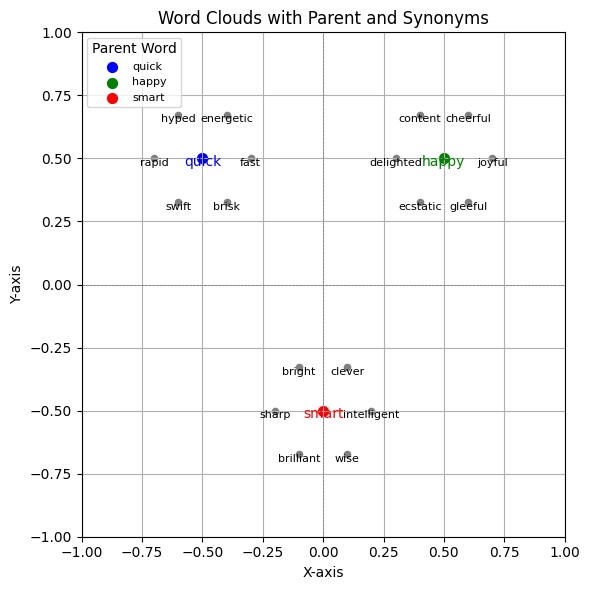

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parent words and their synonyms
word_data = {
    "quick": ["fast", "energetic", "hyped", "rapid", "swift", "brisk"],
    "happy": ["joyful", "cheerful", "content", "delighted", "ecstatic", "gleeful"],
    "smart": ["intelligent", "clever", "bright", "sharp", "brilliant", "wise"]
}

# Function to generate random points within a circle of radius 0.2
def generate_points_in_circle(radius, n_points):
    angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    return x, y

# Plot setup
plt.figure(figsize=(6, 6))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

# Colors for parent words
colors = ['blue', 'green', 'red']
parent_positions = [(-0.5, 0.5), (0.5, 0.5), (0, -0.5)]  # Parent word positions

for idx, (parent_word, synonyms) in enumerate(word_data.items()):
    parent_x, parent_y = parent_positions[idx]

    # Plot parent word
    plt.scatter(parent_x, parent_y, color=colors[idx], s=50, label=f"{parent_word}")
    plt.text(parent_x, parent_y - 0.03, parent_word, color=colors[idx], fontsize=10, ha='center')

    # Generate synonym points around the parent word
    x_offsets, y_offsets = generate_points_in_circle(0.2, len(synonyms))
    for i, synonym in enumerate(synonyms):
        synonym_x = parent_x + x_offsets[i]
        synonym_y = parent_y + y_offsets[i]

        # Plot synonyms
        plt.scatter(synonym_x, synonym_y, color='gray', s=20)
        plt.text(synonym_x, synonym_y - 0.03, synonym, color='black', fontsize=8, ha='center')

# Legend and plot settings
plt.legend(title="Parent Word", loc='upper left', fontsize=8)
plt.title("Word Clouds with Parent and Synonyms", fontsize=12)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.tight_layout()
plt.grid()
plt.show()


## Stage - 4 New :  FFNN Model trained over the other form of Dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape

# Step 1: Load the dataset
data = pd.read_csv('/content/parent-synonym-embedding.csv')  # Replace with your dataset path

# Step 2: Convert embeddings from string to numpy arrays
data['Parent Embedding'] = data['Parent Embedding'].apply(lambda x: np.array(eval(x)))
for i in range(1, 6):
    data[f'Synonym-{i} Embedding'] = data[f'Synonym-{i} Embedding'].apply(lambda x: np.array(eval(x)))

# Step 3: Prepare input (X) and output (y) data
X = np.array(data['Parent Embedding'].tolist())
y = np.array([row[[f'Synonym-{i} Embedding' for i in range(1, 6)]].values.tolist() for _, row in data.iterrows()])

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Define the FFNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(y_train.shape[1] * X_train.shape[1], activation='linear'))   # Output layer with correct shape
model.add(Reshape((y_train.shape[1], X_train.shape[1]))) # Reshape to (batch_size, 5, 20)

# Step 6: Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Step 8: Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

# Step 9: Save the trained model
model.save('paraphrase_model.h5', save_format='tf')
print("Model saved as 'paraphrase_model.h5'")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0537 - mae: 0.1989 - val_loss: 0.0487 - val_mae: 0.1904
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0469 - mae: 0.1862 - val_loss: 0.0450 - val_mae: 0.1824
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0431 - mae: 0.1774 - val_loss: 0.0421 - val_mae: 0.1744
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0401 - mae: 0.1689 - val_loss: 0.0391 - val_mae: 0.1662
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0357 - mae: 0.1573 - val_loss: 0.0359 - val_mae: 0.1577
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0327 - mae: 0.1495 - val_loss: 0.0323 - val_mae: 0.1480
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0293 - mae: 0.1403 - val_loss: 0.0288 - val_mae: 0.1382
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0253 - mae: 0.1289 - val_loss: 0.0255 - val_mae: 0.1287
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - mae: 0.1190 - val_loss: 0

Test Loss: 0.0061045498587191105, Test MAE: 0.055303387343883514
Model saved as 'paraphrase_model.h5'


## Testing of Other Approach

In [ ]:
import numpy as np
import pandas as pd
import csv
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity

# Load trained model
model = load_model('paraphrase_model.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Load word embeddings
file_path = "/content/word_vectors.csv"
existing_vectors = {}
with open(file_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader, None)  # Skip header if present
    for row in reader:
        if len(row) < 2:
            continue  # Skip incomplete rows
        word = row[0].lower()  # Convert to lowercase
        vector = np.array(list(map(float, row[1:])))
        existing_vectors[word] = vector

# Load synonyms.csv
synonyms_df = pd.read_csv('/content/synonyms.csv', header=None, encoding='utf-8')
synonyms_df.rename(columns={0: 'Synonym'}, inplace=True)

# Extract synonym embeddings into a dictionary
synonym_embeddings = np.array(synonyms_df.iloc[:, 1:].values, dtype=np.float32)
synonyms = dict(zip(synonyms_df['Synonym'].str.lower(), synonym_embeddings))  # Convert synonyms to lowercase

# Function to find the closest synonym
def find_closest_synonym(predicted_embedding, synonyms):
    closest_word = None
    max_similarity = -1

    for word, vector in synonyms.items():
        similarity = cosine_similarity(predicted_embedding.reshape(1, -1), vector.reshape(1, -1))[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            closest_word = word

    print(f"Closest synonym found: {closest_word} (Similarity: {max_similarity})", flush=True)
    return closest_word

# Function to paraphrase a sentence
def paraphrase_sentence(sentence, word_vectors, synonyms, model):
    print(f"Paraphrasing sentence: {sentence}", flush=True)
    words = sentence.split()
    paraphrased_sentence = []

    for word in words:
        word_lower = word.lower()  # Ensure lowercase matching

        if word_lower in word_vectors:
            # Get parent embedding
            parent_embedding = word_vectors[word_lower]
            print(f"Embedding for '{word_lower}': {parent_embedding}", flush=True)

            try:
                # Predict synonym embedding
                predicted_synonym_embedding = model.predict(np.array([parent_embedding]))[0][0]
                print(f"Predicted embedding for '{word_lower}': {predicted_synonym_embedding}", flush=True)

                # Find closest synonym
                closest_synonym = find_closest_synonym(predicted_synonym_embedding, synonyms)

                # Replace with synonym if found
                paraphrased_sentence.append(closest_synonym if closest_synonym else word)
            except Exception as e:
                print(f"Error predicting synonym for '{word_lower}': {e}", flush=True)
                paraphrased_sentence.append(word)  # Keep original word on failure
        else:
            print(f"Word '{word_lower}' not found in word vectors, keeping it unchanged.", flush=True)
            paraphrased_sentence.append(word)

    paraphrased_text = ' '.join(paraphrased_sentence)
    print(f"Final paraphrased sentence: {paraphrased_text}", flush=True)
    return paraphrased_text

# Example usage
if __name__ == "__main__":
    print("Starting paraphrasing process...", flush=True)

    # Input sentence
    sentence = "A good OS is very important for any computer to work"

    # Paraphrase the sentence
    paraphrased_sentence = paraphrase_sentence(sentence, existing_vectors, synonyms, model)

    print(f'Original Sentence: {sentence}', flush=True)
    print(f'Paraphrased Sentence: {paraphrased_sentence}', flush=True)


Starting paraphrasing process...
Paraphrasing sentence: A good OS is very important for any computer to work
Word 'a' not found in word vectors, keeping it unchanged.
Embedding for 'good': [ 0.0645351   0.12280249 -0.33764008 -0.41355038  0.378481    0.20488854
  0.04473563  0.04131005  0.4716147   0.24109986 -0.20663923  0.03755432
 -0.41947204  0.15695728 -0.0469012   0.09187546  0.38739452 -0.36211875
 -0.06866102 -0.380013  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Predicted embedding for 'good': [-0.02526145  0.08578657 -0.13811466 -0.20539933  0.24849561  0.1191608
 -0.03446578  0.05437978  0.32295236  0.0738818  -0.22213957  0.05920267
 -0.42811394  0.14792715 -0.08265159  0.08332124  0.3173039  -0.3936814
 -0.09399584 -0.33402264]
Closest synonym found: right (Similarity: 0.9350704550743103)
Word 'os' not found in word vectors, keeping it unchanged.
Word 'is' not found in word vectors, keeping it unchanged.
Word 'very' not found in word vectors, keeping it unchanged.
Embedding fo

New Model Accuracy Display

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - cosine_similarity_accuracy: 0.0298 - loss: 0.0524 - mae: 0.1975 - val_cosine_similarity_accuracy: 0.1987 - val_loss: 0.0484 - val_mae: 0.1908
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - cosine_similarity_accuracy: 0.2782 - loss: 0.0472 - mae: 0.1874 - val_cosine_similarity_accuracy: 0.3161 - val_loss: 0.0454 - val_mae: 0.1843
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - cosine_similarity_accuracy: 0.3880 - loss: 0.0436 - mae: 0.1787 - val_cosine_similarity_accuracy: 0.3808 - val_loss: 0.0427 - val_mae: 0.1772
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - cosine_similarity_accuracy: 0.4485 - loss: 0.0406 - mae: 0.1707 - val_cosine_similarity_accuracy: 0.4440 - val_loss: 0.0398 - val_mae: 0.1692
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - cosine_similarity_accuracy: 0.5166 - loss: 0.0369 - mae: 0.1609 - val_cosine_similarity_accuracy: 0.5101 - val_loss: 0.0366 - val_mae: 0.1604
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/st

Test Loss: 0.006141237914562225, Test MAE: 0.05531163141131401, Test Accuracy (Cosine Similarity): 0.9359040856361389
Model saved as 'paraphrase_model.h5'


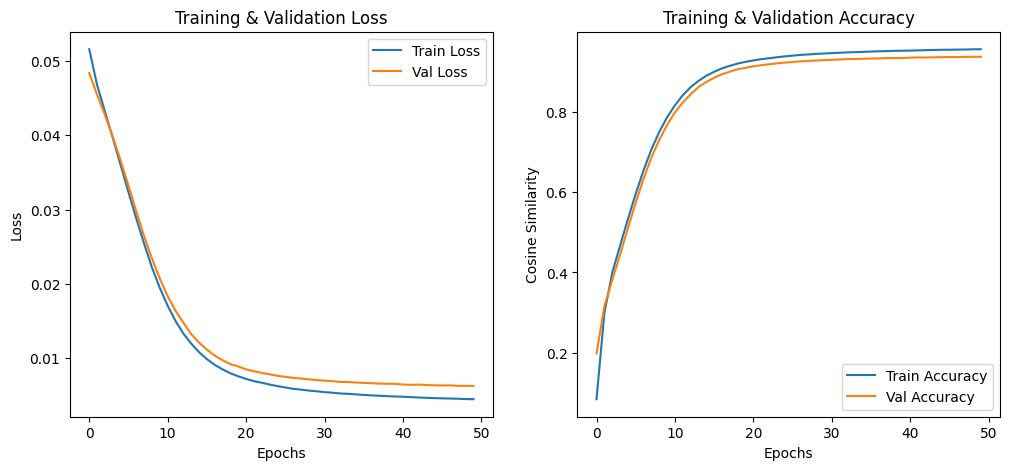

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

# Step 1: Load the dataset
data = pd.read_csv('/content/parent-synonym-embedding.csv')  # Replace with your dataset path

# Step 2: Convert embeddings from string to numpy arrays
data['Parent Embedding'] = data['Parent Embedding'].apply(lambda x: np.array(eval(x)))
for i in range(1, 6):
    data[f'Synonym-{i} Embedding'] = data[f'Synonym-{i} Embedding'].apply(lambda x: np.array(eval(x)))

# Step 3: Prepare input (X) and output (y) data
X = np.array(data['Parent Embedding'].tolist())
y = np.array([row[[f'Synonym-{i} Embedding' for i in range(1, 6)]].values.tolist() for _, row in data.iterrows()])

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Define Cosine Similarity Accuracy
def cosine_similarity_accuracy(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis=-1)  # Normalize embeddings
    y_pred = K.l2_normalize(y_pred, axis=-1)
    return K.mean(K.sum(y_true * y_pred, axis=-1))  # Cosine similarity as accuracy

# Step 6: Define the FFNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(y_train.shape[1] * X_train.shape[1], activation='linear'))   # Output layer with correct shape
model.add(Reshape((y_train.shape[1], X_train.shape[1])))  # Reshape to (batch_size, 5, 20)

# Step 7: Compile the model with accuracy metric
model.compile(optimizer='adam', loss='mse', metrics=['mae', cosine_similarity_accuracy])

# Step 8: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Step 9: Evaluate the model on the test set
loss, mae, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}, Test Accuracy (Cosine Similarity): {accuracy}')

# Step 10: Save the trained model
model.save('paraphrase_model.h5', save_format='tf')  # Changed to model.save and specify format
print("Model saved as 'paraphrase_model.h5'")

# Step 11: Plot training history (Loss & Accuracy)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['cosine_similarity_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_cosine_similarity_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Cosine Similarity')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Original Sentences
original_sentences = [
    "Once there lived a quick brown fox.",
    "The bank is near the bank of a river",
    "The fox leaped across the huge wall to get the juicy grapes.",
    "He lived in Australia for the past four years",
    "A good OS is very important for any computer to work ",
    "The rock climber grabbed onto a rock while scaling the cliff.",
    "The sailors planned to sail after they finished repairing the sail of the boat.",
    "She walked to the store.",
    "The cat slept on the couch.",
    "The birds flew across the sky."
]

# Paraphrased Sentences
paraphrased_sentences = [
    "former at that place lived a quick brownish fox",
    "The bank is nearby the bank of a creek",
    "The fox jumped across the big wall to get the juicier grapes",
    "He resided in Australia for over four years",
    "A right OS is very profound for any computer to work",
    "The rock mountaineer snatched off a rockers instead scaling the ledge.",
    "The sailor plans for sailing after they finish repair the sailing of the boat.",
    "She strode to the stores.",
    "The kitten sleeps upon the couch.",
    "The birds flew crossed the sky."
]

# Compute sentence embeddings
original_embeddings = model.encode(original_sentences, convert_to_tensor=True)
paraphrased_embeddings = model.encode(paraphrased_sentences, convert_to_tensor=True)

# Compute cosine similarity
similarities = [
    round(float(cosine_similarity([original.cpu().numpy()], [paraphrased.cpu().numpy()])[0][0]), 4)
    for original, paraphrased in zip(original_embeddings, paraphrased_embeddings)
]

# Print results
for i, (orig, para, sim) in enumerate(zip(original_sentences, paraphrased_sentences, similarities)):
    print(f"Sentence {i+1}:")
    print(f"Original   : {orig}")
    print(f"Paraphrased: {para}")
    print(f"Similarity : {sim}\n")

# Return similarity scores
similarities


Sentence 1:
Original   : Once there lived a quick brown fox.
Paraphrased: former at that place lived a quick brownish fox
Similarity : 0.7997

Sentence 2:
Original   : The bank is near the bank of a river
Paraphrased: The bank is nearby the bank of a creek
Similarity : 0.8644

Sentence 3:
Original   : The fox leaped across the huge wall to get the juicy grapes.
Paraphrased: The fox jumped across the big wall to get the juicier grapes
Similarity : 0.8954

Sentence 4:
Original   : He lived in Australia for the past four years
Paraphrased: He resided in Australia for over four years
Similarity : 0.9608

Sentence 5:
Original   : A good OS is very important for any computer to work 
Paraphrased: A right OS is very profound for any computer to work
Similarity : 0.8218

Sentence 6:
Original   : The rock climber grabbed onto a rock while scaling the cliff.
Paraphrased: The rock mountaineer snatched off a rockers instead scaling the ledge.
Similarity : 0.7326

Sentence 7:
Original   : The sailo

[0.7997,
 0.8644,
 0.8954,
 0.9608,
 0.8218,
 0.7326,
 0.8995,
 0.9074,
 0.8276,
 0.9485]

## Performance Evaluations Done
1. Word2Vec vs WC-SPRM time taken

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import time
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

import os
from nltk.tokenize import word_tokenize

def load_stopwords(file_path="stopwords.txt"):
    """Loads stopwords from a file."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Error: {file_path} not found.")

    with open(file_path, "r", encoding="utf-8") as f:
        stop_words = set(f.read().splitlines())

    return stop_words

def paraphrase_sentence(sentence, stopwords_file="stopwords.txt"):
    """Paraphrases a sentence by replacing non-stopwords with similar words."""
    stop_words = load_stopwords(stopwords_file)
    words = word_tokenize(sentence)
    paraphrased_words = []

    for word in words:
        if word.lower() not in stop_words and word.isalpha():  # Replace only non-stopwords
            paraphrased_word = find_similar_word(word)
            paraphrased_words.append(paraphrased_word)
        else:
            paraphrased_words.append(word)

    return " ".join(paraphrased_words)


# Load pre-trained Word2Vec model
print("Loading Word2Vec model...")
start_load_time = time.time()
word2vec_model = api.load("word2vec-google-news-300")  # Load Google's Word2Vec model
end_load_time = time.time()
print(f"Model loaded in {end_load_time - start_load_time:.2f} seconds.")

# Function to find the most similar word in the Word2Vec model
def find_similar_word(word):
    try:
        similar_words = word2vec_model.most_similar(word, topn=5)  # Get top 5 similar words
        return similar_words[0][0]  # Return the most similar word
    except KeyError:
        return word  # Return the original word if it's not in the vocabulary


# Function to compute time taken for paraphrase generation
def generate_paraphrase(sentence):
    start_time = time.time()
    paraphrased_sentence = paraphrase_sentence(sentence)
    end_time = time.time()
    time_taken = end_time - start_time
    return paraphrased_sentence, time_taken

# Example usage
if __name__ == "__main__":
    sentence = "The birds flew across the sky."
    print(f"Original Sentence: {sentence}")

    paraphrased_sentence, time_taken = generate_paraphrase(sentence)
    print(f"Paraphrased Sentence: {paraphrased_sentence}")
    print(f"Time taken for paraphrase generation: {time_taken:.4f} seconds")

Loading Word2Vec model...
Model loaded in 57.58 seconds.
Original Sentence: The birds flew across the sky.
Paraphrased Sentence: The bird flown Across the skies .
Time taken for paraphrase generation: 6.5728 seconds


In [ ]:
import numpy as np
import pandas as pd
import csv
import time
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity

# Measure model loading time
start_time = time.time()
model = load_model('paraphrase_model.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_load_time = time.time() - start_time
print(f"Model loaded in {model_load_time:.4f} seconds.")

# Load word embeddings
file_path = "/content/word_vectors.csv"
existing_vectors = {}
with open(file_path, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    next(reader, None)  # Skip header if present
    for row in reader:
        if len(row) < 2:
            continue  # Skip incomplete rows
        word = row[0].lower()  # Convert to lowercase
        vector = np.array(list(map(float, row[1:])))
        existing_vectors[word] = vector

# Load synonyms.csv
synonyms_df = pd.read_csv('/content/synonyms.csv', header=None, encoding='utf-8')
synonyms_df.rename(columns={0: 'Synonym'}, inplace=True)

# Extract synonym embeddings into a dictionary
synonym_embeddings = np.array(synonyms_df.iloc[:, 1:].values, dtype=np.float32)
synonyms = dict(zip(synonyms_df['Synonym'].str.lower(), synonym_embeddings))  # Convert synonyms to lowercase

# Function to find the closest synonym
def find_closest_synonym(predicted_embedding, synonyms):
    closest_word = None
    max_similarity = -1

    for word, vector in synonyms.items():
        similarity = cosine_similarity(predicted_embedding.reshape(1, -1), vector.reshape(1, -1))[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            closest_word = word

    print(f"Closest synonym found: {closest_word} (Similarity: {max_similarity})", flush=True)
    return closest_word

# Function to paraphrase a sentence
def paraphrase_sentence(sentence, word_vectors, synonyms, model):
    start_time = time.time()  # Start time for paraphrasing

    print(f"Paraphrasing sentence: {sentence}", flush=True)
    words = sentence.split()
    paraphrased_sentence = []

    for word in words:
        word_lower = word.lower()  # Ensure lowercase matching

        if word_lower in word_vectors:
            # Get parent embedding
            parent_embedding = word_vectors[word_lower]
            print(f"Embedding for '{word_lower}': {parent_embedding}", flush=True)

            try:
                # Predict synonym embedding
                predicted_synonym_embedding = model.predict(np.array([parent_embedding]))[0][0]
                print(f"Predicted embedding for '{word_lower}': {predicted_synonym_embedding}", flush=True)

                # Find closest synonym
                closest_synonym = find_closest_synonym(predicted_synonym_embedding, synonyms)

                # Replace with synonym if found
                paraphrased_sentence.append(closest_synonym if closest_synonym else word)
            except Exception as e:
                print(f"Error predicting synonym for '{word_lower}': {e}", flush=True)
                paraphrased_sentence.append(word)  # Keep original word on failure
        else:
            print(f"Word '{word_lower}' not found in word vectors, keeping it unchanged.", flush=True)
            paraphrased_sentence.append(word)

    paraphrased_text = ' '.join(paraphrased_sentence)

    paraphrase_time = time.time() - start_time  # Calculate time taken
    print(f"Paraphrased in {paraphrase_time:.4f} seconds.")
    print(f"Final paraphrased sentence: {paraphrased_text}", flush=True)

    return paraphrased_text, paraphrase_time

# Example usage
if __name__ == "__main__":
    print("Starting paraphrasing process...", flush=True)

    # Input sentence
    sentence = "The birds flew across the sky."

    # Paraphrase the sentence
    paraphrased_sentence, time_taken = paraphrase_sentence(sentence, existing_vectors, synonyms, model)

    print(f'Original Sentence: {sentence}', flush=True)
    print(f'Paraphrased Sentence: {paraphrased_sentence}', flush=True)
    print(f'Time Taken for Paraphrasing: {time_taken:.4f} seconds', flush=True)


Model loaded in 0.0995 seconds.
Starting paraphrasing process...
Paraphrasing sentence: The birds flew across the sky.
Word 'the' not found in word vectors, keeping it unchanged.
Word 'birds' not found in word vectors, keeping it unchanged.
Word 'flew' not found in word vectors, keeping it unchanged.
Embedding for 'across': [ 0.26462546  0.01461064 -0.3871996  -0.38562927  0.08384034 -0.1929913
 -0.2820583   0.3841145  -0.08642838 -0.30501693 -0.32470647  0.02925833
 -0.2656427   0.0169149  -0.27875504 -0.07436827 -0.274443   -0.3134061
 -0.38256663  0.17824894]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted embedding for 'across': [ 0.15696204  0.02057954 -0.26009378 -0.28059968  0.02964197 -0.09838544
 -0.1857642   0.2863722  -0.05857152 -0.18207401 -0.30096656  0.02335045
 -0.27632007 -0.0063029  -0.3058357  -0.0807385  -0.30719241 -0.378688
 -0.36881575  0.20592627]
Closest synonym found: crossed (Similarity: 0.966810941696167)
Word 'the' not found in word vectors, keeping it unch

Word2Vec vs WC-SPRM Execution Time Vissualisation

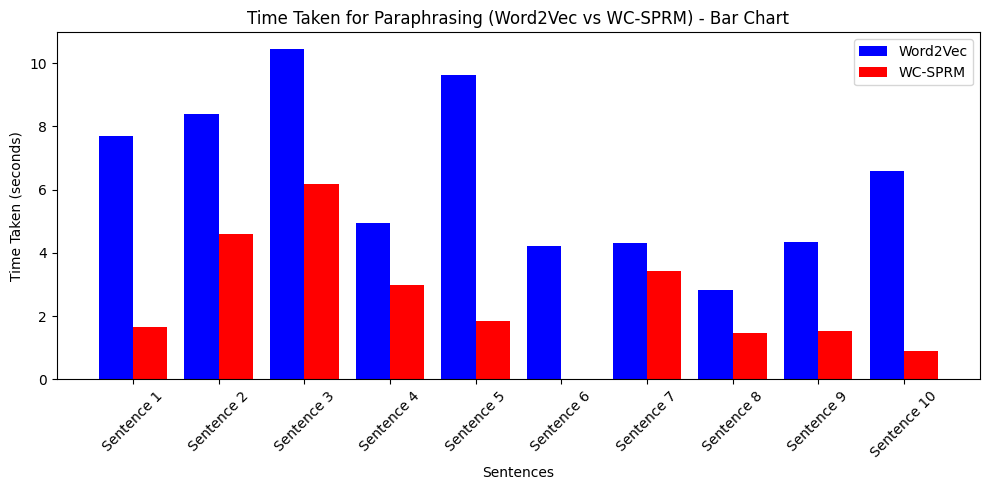

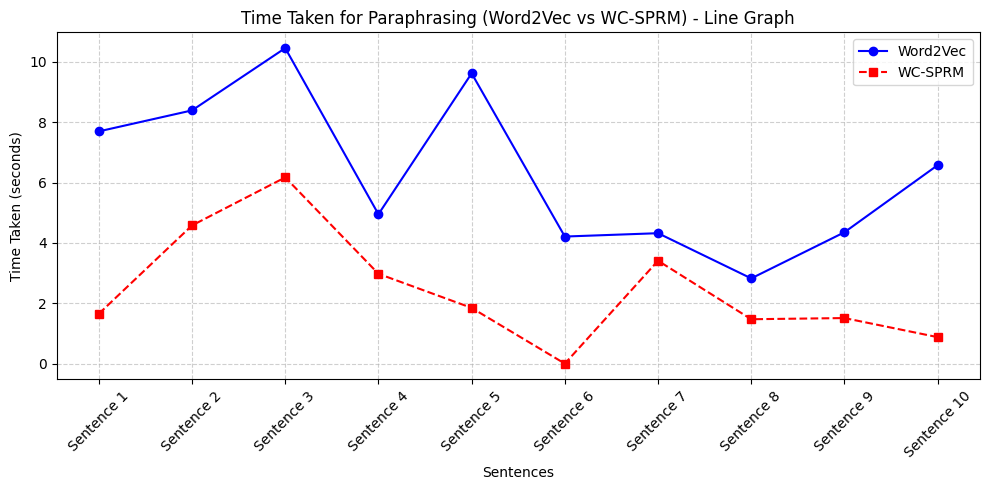

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your final stats table
sentences = [
    "Sentence 1", "Sentence 2", "Sentence 3", "Sentence 4", "Sentence 5",
    "Sentence 6", "Sentence 7", "Sentence 8", "Sentence 9", "Sentence 10"
]

word2vec_time = [7.6918, 8.3863, 10.4472, 4.9498, 9.6119 , 4.2117, 4.3224, 2.8265, 4.3531, 6.5728]
wc_sprm_time = [1.6568, 4.5798, 6.1690, 2.9794, 1.8505, 0.0067, 3.4113, 1.4753, 1.5143,  0.8831]

x = np.arange(len(sentences))  # X-axis positions

# Bar Chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar(x - bar_width/2, word2vec_time, width=bar_width, label="Word2Vec", color="b")
plt.bar(x + bar_width/2, wc_sprm_time, width=bar_width, label="WC-SPRM", color="r")
plt.xticks(x, sentences, rotation=45)
plt.xlabel("Sentences")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken for Paraphrasing (Word2Vec vs WC-SPRM) - Bar Chart")
plt.legend()
plt.tight_layout()
plt.show()

# Line Graph
plt.figure(figsize=(10, 5))
plt.plot(sentences, word2vec_time, color='b', marker="o", linestyle='-', label="Word2Vec")
plt.plot(sentences, wc_sprm_time, color='r', marker="s", linestyle='--', label="WC-SPRM")
plt.xlabel("Sentences")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken for Paraphrasing (Word2Vec vs WC-SPRM) - Line Graph")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
